In [1]:
!pip install datasets -q
!pip install accelerate -U -q
!pip install bitsandbytes -q
!pip install pynvml -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.0 MB/s eta 0:00:00


In [2]:
from transformers import TrainingArguments, Trainer, logging
import bitsandbytes as bnb
from accelerate import Accelerator

In [3]:
from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [4]:
print_gpu_utilization()

GPU memory occupied: 451 MB.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from datasets import load_dataset


dataset_path = r"/content/drive/MyDrive/DS 5500 Capstone/Capstone (Shared)/Full Flickr 8k"
dataset = load_dataset(dataset_path)

Resolving data files:   0%|          | 0/6473 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1620 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [7]:
test_ds, train_ds = dataset['test'], dataset['train']

In [8]:
test_ds

Dataset({
    features: ['image', 'text'],
    num_rows: 1619
})

In [9]:
train_ds

Dataset({
    features: ['image', 'text'],
    num_rows: 6472
})

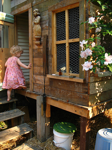

In [10]:
example = train_ds[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [11]:
example['text']

'a child in a pink dress is climbing up a set of stairs in an entry way'

#### Creating PyTorch Dataset

In [12]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [13]:
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained("microsoft/git-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [14]:
train_dataset = ImageCaptioningDataset(train_ds, processor)
test_dataset = ImageCaptioningDataset(test_ds,processor)

In [15]:
item = train_dataset[0]
for k,v in item.items(): print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


### Create a Pytorch DataLoader

In [18]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=20)   # increased with 2

In [19]:
batch = next(iter(train_dataloader))
for k,v in batch.items(): print(k,v.shape)

input_ids torch.Size([20, 512])
attention_mask torch.Size([20, 512])
pixel_values torch.Size([20, 3, 224, 224])


Lets check one batch and do some sanity checks

In [22]:
processor.decode(batch["input_ids"][0])

'[CLS] a young girl does a handstand on a bed with blue sheets [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

We can denormalize the values to get back an image

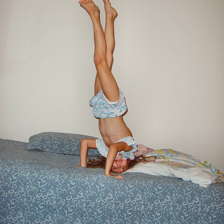

In [23]:
from PIL import Image
import numpy as np
MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255
unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

### Defining the Model

change the model according to your needs

In [24]:
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")
print_gpu_utilization()

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

GPU memory occupied: 451 MB.


Dummy forward pass

Checking initial loss on a batch

In [25]:
outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], pixel_values=batch["pixel_values"], labels=batch["input_ids"])
outputs.loss

tensor(11.9595, grad_fn=<NllLossBackward0>)

## Train the model

Training the model using native pytorch here

In [26]:
import torch
# first run the code with attention_mask commented and after your recieve a warning for adding attention mask --> uncomment the 'attention_mask' line and run the program again
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
device = "cuda" if torch.cuda.is_available() else "cpu"
accelerator = Accelerator(gradient_accumulation_steps=4)
model.to(device)
model.train()
for epoch in range(5):
    print("Epoch:", epoch)
    for idx, batch in enumerate(train_dataloader):
      with accelerator.accumulate(model):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)
        #attention_mask = batch.pop("attention_mask").to(device)  # added -- attention masking    # comment and uncomment
        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)
        loss = outputs.loss
        if idx % 10 == 0:
          print("Loss:", loss.item() , "current epoch " , epoch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 12.598938941955566 current epoch  0
Loss: 8.542084693908691 current epoch  0
Loss: 7.500463008880615 current epoch  0
Loss: 6.493671894073486 current epoch  0
Loss: 5.423657417297363 current epoch  0
Loss: 4.306961536407471 current epoch  0
Loss: 3.184683322906494 current epoch  0
Loss: 2.1271586418151855 current epoch  0
Loss: 1.2417479753494263 current epoch  0
Loss: 0.6725484132766724 current epoch  0
Loss: 0.38259556889533997 current epoch  0
Loss: 0.25338080525398254 current epoch  0
Loss: 0.21221691370010376 current epoch  0
Loss: 0.16590116918087006 current epoch  0
Loss: 0.14810389280319214 current epoch  0
Loss: 0.12361664324998856 current epoch  0
Loss: 0.1201241984963417 current epoch  0
Loss: 0.1105947270989418 current epoch  0
Loss: 0.10144490003585815 current epoch  0
Loss: 0.09611787647008896 current epoch  0
Loss: 0.09612326323986053 current epoch  0
Loss: 0.09078548103570938 current epoch  0
Loss: 0.09496094286441803 current epoch  0
Loss: 0.07784226536750793 cur

# Inference

### Now that we have trained the model, lets load the image and perform inference on it

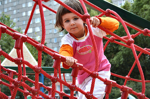

In [27]:
# load image
example = dataset['train'][3]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [28]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

a small child climbs on a playground


In [29]:
# saving the entire model
torch.save(model.state_dict(), "finetuned_model_grad")

# saving the optimizer state
torch.save(optimizer.state_dict(), "optimizer_state_grad")

#### Inference from the saved model

Loading the saved model

In [30]:
# Load the saved model and optimizer
loaded_model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")
loaded_optimizer = torch.optim.AdamW(loaded_model.parameters(), lr=5e-5)

# Load the saved model and optimizer state
loaded_model.load_state_dict(torch.load('finetuned_model_grad'))
loaded_optimizer.load_state_dict(torch.load('optimizer_state_grad'))

# Set the model to evaluation mode for inference
loaded_model.eval()

# Process the New Image
loaded_model.to(device)

GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
          (position_embedding): Embedding(197, 768)
        )
        (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0-11): 12 x GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
             

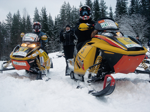

a group of people in yellow and black snow gear and yellow snowmobiles


In [31]:
example = dataset['test'][20]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

# generate the samples
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values
generated_ids = loaded_model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

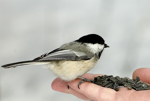

a small bird is eating a snack


In [32]:
example = dataset['test'][25]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

# generate the samples
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values
generated_ids = loaded_model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

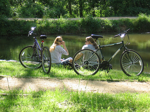

two young girls sit on the grass near a bike


In [33]:
example = dataset['test'][76]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

# generate the samples
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values
generated_ids = loaded_model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)